## Notebook 10: River Response to Storms

**When it rains in Kansas City, how long until the Missouri River rises in St. Louis?**

Rivers are the arteries of the landscape, collecting rainfall from vast areas and funneling it downstream. When a storm drops inches of rain on Kansas City, that water doesn't instantly appear 250 miles downstream in St. Louis. It takes time—and tracking that **flood wave** as it moves downstream is critical for flood forecasting.

In this notebook, we'll:

- Fetch real streamflow data from USGS gaging stations
- Plot discharge over time to see how rivers respond to storms
- Compare upstream vs downstream stations to watch the flood wave travel
- Calculate the lag time between stations
- Connect rainfall to river response

## Setup

Same initialization as previous notebooks, plus tools for fetching USGS data.

In [27]:
%pip install -q geemap folium matplotlib

Note: you may need to restart the kernel to use updated packages.


In [28]:
import ee
from google.cloud import storage
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import json
import urllib.request
from datetime import datetime, timedelta

# Initialize Earth Engine
PROJECT = "eeps-geospatial"
BUCKET = "wustl-eeps-edc"
ee.Initialize(project=PROJECT)

import geemap.foliumap as geemap

print("Ready!")

Ready!


## What is streamflow?

**Streamflow** (or discharge) is the volume of water flowing past a point per unit time. It's typically measured in **cubic feet per second (cfs)** in the US.

**How is it measured?**

The USGS operates over 10,000 **stream gages** across the United States. Each gage:
1. Continuously measures **water level** (stage) using pressure sensors or floats
2. Converts stage to discharge using a **rating curve** developed from field measurements
3. Transmits data via satellite every 15-60 minutes

**Key concepts:**

| Term | Definition |
|------|------------|
| **Discharge (Q)** | Volume of water per time (cfs or m³/s) |
| **Stage** | Water surface elevation above a datum (feet) |
| **Hydrograph** | Plot of discharge vs time |
| **Peak flow** | Maximum discharge during an event |
| **Base flow** | Discharge between storms (groundwater contribution) |
| **Rising limb** | Increasing discharge as storm runoff arrives |
| **Falling limb** | Decreasing discharge as flood recedes |

**Scale of discharge:**
- Small creek: 10-100 cfs
- Medium river: 1,000-10,000 cfs
- Missouri River at KC: ~30,000-50,000 cfs (normal), 200,000+ cfs (flood)
- Mississippi at St. Louis: ~100,000-200,000 cfs (normal), 1,000,000+ cfs (major flood)

## Define study area and gaging stations

We'll track water as it moves down the Missouri River and into the Mississippi:

1. **Missouri River at Kansas City, MO** (06893000) - upstream
2. **Missouri River at Hermann, MO** (06934500) - midway
3. **Mississippi River at St. Louis, MO** (07010000) - downstream (below Missouri confluence)

The Missouri River joins the Mississippi just north of St. Louis, so the St. Louis gage captures flow from both rivers.

In [29]:
# USGS gaging stations along the Missouri/Mississippi
stations = {
    '06893000': {
        'name': 'Missouri River at Kansas City',
        'lat': 39.1075,
        'lon': -94.5953,
        'river_mile': 366,  # miles above mouth
        'color': '#e41a1c'  # red
    },
    '06934500': {
        'name': 'Missouri River at Hermann',
        'lat': 38.7092,
        'lon': -91.4383,
        'river_mile': 98,
        'color': '#377eb8'  # blue
    },
    '07010000': {
        'name': 'Mississippi River at St. Louis',
        'lat': 38.6247,
        'lon': -90.1807,
        'river_mile': 0,  # reference point
        'color': '#4daf4a'  # green
    }
}

# Distance between stations (approximate river miles)
kc_to_hermann = 366 - 98  # ~268 miles
hermann_to_stl = 98  # ~98 miles to confluence, plus Mississippi distance

print("Gaging stations:")
for site_id, info in stations.items():
    print(f"  {site_id}: {info['name']}")
print(f"\nKansas City to Hermann: ~{kc_to_hermann} river miles")
print(f"Hermann to St. Louis: ~{hermann_to_stl} river miles")

Gaging stations:
  06893000: Missouri River at Kansas City
  06934500: Missouri River at Hermann
  07010000: Mississippi River at St. Louis

Kansas City to Hermann: ~268 river miles
Hermann to St. Louis: ~98 river miles


In [30]:
# Create map showing station locations
m = geemap.Map(center=[38.9, -92.5], zoom=7)

# Add station markers
for site_id, info in stations.items():
    point = ee.Geometry.Point([info['lon'], info['lat']])
    m.addLayer(point, {'color': info['color']}, info['name'])

# Add state boundaries for context
states = ee.FeatureCollection("TIGER/2018/States")
mo_ks = states.filter(ee.Filter.inList("NAME", ["Missouri", "Kansas", "Illinois"]))
m.addLayer(mo_ks.style(fillColor='00000000', color='666666', width=1), {}, 'States')

print("Red = Kansas City | Blue = Hermann | Green = St. Louis")
print("Water flows from west (KC) to east (St. Louis)")
m

Red = Kansas City | Blue = Hermann | Green = St. Louis
Water flows from west (KC) to east (St. Louis)


## Fetch USGS streamflow data

The USGS Water Services API provides free access to real-time and historical streamflow data. We'll fetch **daily mean discharge** for our stations.

API endpoint: `https://waterservices.usgs.gov/nwis/dv/`

Key parameters:
- `sites`: USGS station number(s)
- `parameterCd`: 00060 = discharge (cfs)
- `startDT`, `endDT`: date range
- `format`: json

In [31]:
def fetch_usgs_daily(site_id, start_date, end_date):
    """
    Fetch daily mean discharge from USGS Water Services.
    
    Parameters:
        site_id: USGS station number (string)
        start_date: Start date (YYYY-MM-DD)
        end_date: End date (YYYY-MM-DD)
    
    Returns:
        List of (datetime, discharge_cfs) tuples
    """
    base_url = "https://waterservices.usgs.gov/nwis/dv/"
    params = (
        f"?format=json"
        f"&sites={site_id}"
        f"&parameterCd=00060"  # Discharge
        f"&startDT={start_date}"
        f"&endDT={end_date}"
        f"&siteStatus=all"
    )
    
    url = base_url + params
    
    with urllib.request.urlopen(url, timeout=60) as response:
        data = json.loads(response.read().decode())
    
    # Parse the JSON response
    results = []
    try:
        time_series = data['value']['timeSeries'][0]
        values = time_series['values'][0]['value']
        
        for v in values:
            date_str = v['dateTime'][:10]  # YYYY-MM-DD
            date = datetime.strptime(date_str, '%Y-%m-%d')
            discharge = float(v['value']) if v['value'] != '-999999' else None
            if discharge is not None and discharge >= 0:
                results.append((date, discharge))
    except (KeyError, IndexError) as e:
        print(f"Warning: Could not parse data for site {site_id}: {e}")
    
    return results

print("Fetch function defined")

Fetch function defined


In [32]:
# Fetch one year of data (2024)
start_date = "2024-01-01"
end_date = "2024-12-31"

print(f"Fetching daily discharge data for {start_date} to {end_date}...")

# Fetch data for each station
station_data = {}
for site_id, info in stations.items():
    print(f"  Fetching {info['name']}...")
    data = fetch_usgs_daily(site_id, start_date, end_date)
    station_data[site_id] = data
    print(f"    Retrieved {len(data)} daily values")

print("\nData fetched successfully!")

Fetching daily discharge data for 2024-01-01 to 2024-12-31...
  Fetching Missouri River at Kansas City...
    Retrieved 366 daily values
  Fetching Missouri River at Hermann...
    Retrieved 366 daily values
  Fetching Mississippi River at St. Louis...
    Retrieved 366 daily values

Data fetched successfully!


## Annual hydrograph: A year in the life of the Missouri River

Let's plot discharge for all three stations over the full year. This shows:
- Seasonal patterns (spring snowmelt, summer storms)
- Major flood events
- How upstream events propagate downstream

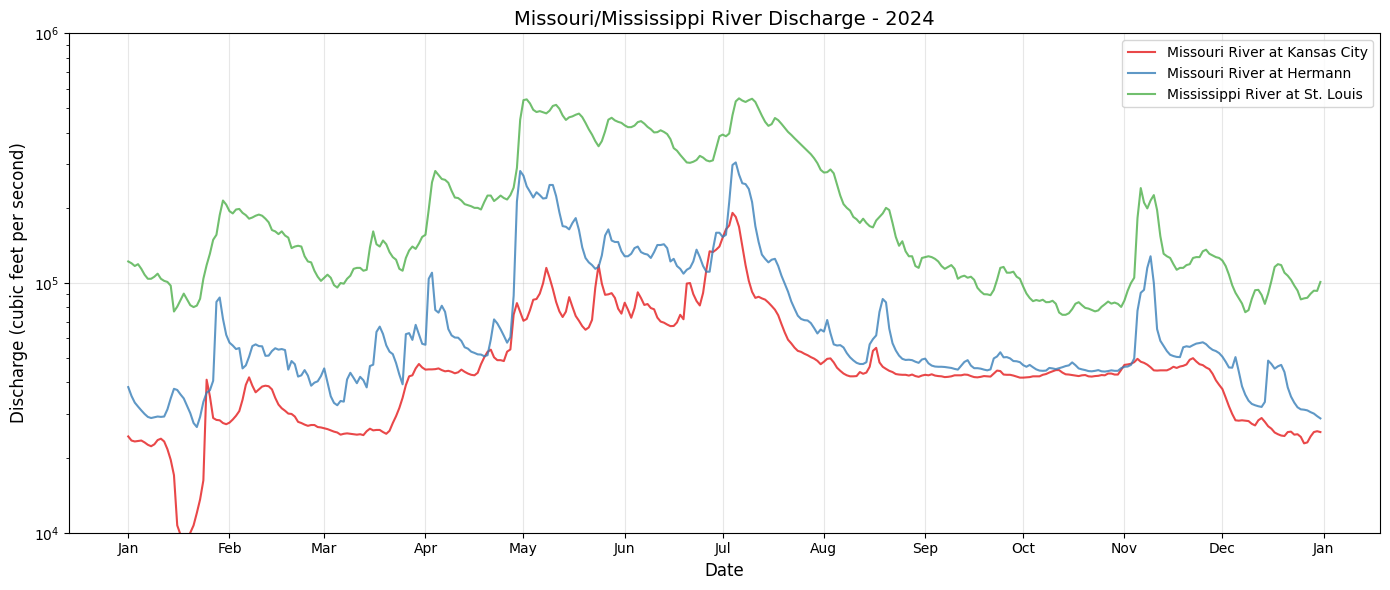


Note: Y-axis is logarithmic to show all stations on one plot
The Mississippi at St. Louis (green) has higher flow because it
receives water from both the Missouri and upper Mississippi rivers.


In [33]:
# Create annual hydrograph
fig, ax = plt.subplots(figsize=(14, 6))

for site_id, info in stations.items():
    data = station_data[site_id]
    if data:
        dates = [d[0] for d in data]
        discharge = [d[1] for d in data]
        ax.plot(dates, discharge, '-', color=info['color'], 
                linewidth=1.5, label=info['name'], alpha=0.8)

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Discharge (cubic feet per second)', fontsize=12)
ax.set_title('Missouri/Mississippi River Discharge - 2024', fontsize=14)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

# Format x-axis dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_major_locator(mdates.MonthLocator())

# Use log scale to see all three rivers on same plot
ax.set_yscale('log')
ax.set_ylim(10000, 1000000)

plt.tight_layout()
plt.show()

print("\nNote: Y-axis is logarithmic to show all stations on one plot")
print("The Mississippi at St. Louis (green) has higher flow because it")
print("receives water from both the Missouri and upper Mississippi rivers.")

## Zoom in: A storm event

Let's find a period with elevated flows and examine how the flood wave moves downstream. We'll look for a time when discharge increased significantly at Kansas City and track that pulse to St. Louis.

In [34]:
# Find peak discharge events at Kansas City
kc_data = station_data['06893000']
kc_dates = [d[0] for d in kc_data]
kc_discharge = [d[1] for d in kc_data]

# Find dates with above-average discharge
mean_q = np.mean(kc_discharge)
std_q = np.std(kc_discharge)
threshold = mean_q + 1.5 * std_q

print(f"Kansas City discharge statistics:")
print(f"  Mean: {mean_q:,.0f} cfs")
print(f"  Std Dev: {std_q:,.0f} cfs")
print(f"  Threshold (mean + 1.5σ): {threshold:,.0f} cfs")
print(f"\nDates exceeding threshold:")

high_flow_dates = []
for i, (date, q) in enumerate(kc_data):
    if q > threshold:
        high_flow_dates.append(date)

# Group consecutive dates into events
if high_flow_dates:
    events = []
    current_event = [high_flow_dates[0]]
    for i in range(1, len(high_flow_dates)):
        if (high_flow_dates[i] - high_flow_dates[i-1]).days <= 7:
            current_event.append(high_flow_dates[i])
        else:
            events.append(current_event)
            current_event = [high_flow_dates[i]]
    events.append(current_event)
    
    print(f"  Found {len(events)} distinct high-flow events")
    for i, event in enumerate(events[:5]):
        print(f"  Event {i+1}: {event[0].strftime('%b %d')} - {event[-1].strftime('%b %d')}")

Kansas City discharge statistics:
  Mean: 50,147 cfs
  Std Dev: 28,313 cfs
  Threshold (mean + 1.5σ): 92,617 cfs

Dates exceeding threshold:
  Found 3 distinct high-flow events
  Event 1: May 07 - May 10
  Event 2: May 23 - May 25
  Event 3: Jun 20 - Jul 09


Examining period: May 02 - May 23, 2024


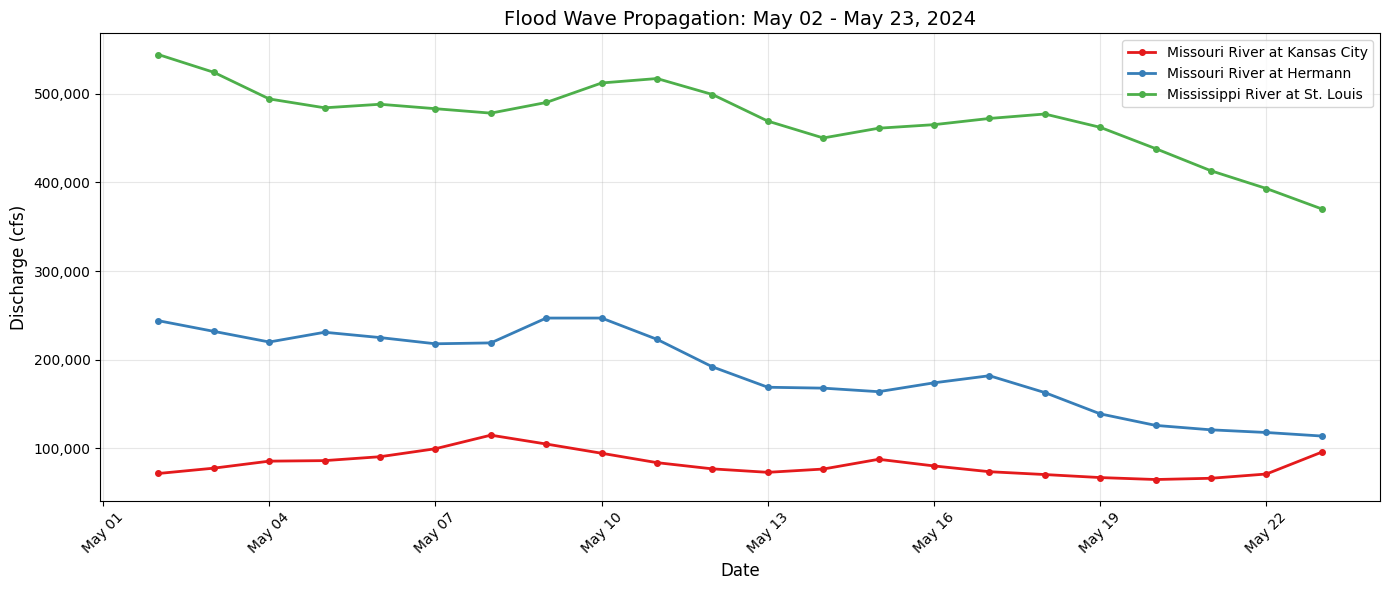


Watch how the peak moves from Kansas City (red) to Hermann (blue) to St. Louis (green)
The delay between peaks is the flood wave travel time.


In [35]:
# Select a specific event period to examine
# We'll look at a 3-week window around a high-flow event
if events:
    # Use the first significant event
    event_center = events[0][len(events[0])//2]
    event_start = event_center - timedelta(days=7)
    event_end = event_center + timedelta(days=14)
else:
    # Fallback to a spring period
    event_start = datetime(2024, 5, 1)
    event_end = datetime(2024, 5, 31)

print(f"Examining period: {event_start.strftime('%b %d')} - {event_end.strftime('%b %d')}, 2024")

# Filter data to event period
fig, ax = plt.subplots(figsize=(14, 6))

for site_id, info in stations.items():
    data = station_data[site_id]
    # Filter to event period
    event_data = [(d, q) for d, q in data if event_start <= d <= event_end]
    if event_data:
        dates = [d[0] for d in event_data]
        discharge = [d[1] for d in event_data]
        ax.plot(dates, discharge, 'o-', color=info['color'], 
                linewidth=2, markersize=4, label=info['name'])

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Discharge (cfs)', fontsize=12)
ax.set_title(f'Flood Wave Propagation: {event_start.strftime("%b %d")} - {event_end.strftime("%b %d")}, 2024', fontsize=14)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

# Format x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
plt.xticks(rotation=45)

# Format y-axis with thousands separator
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.tight_layout()
plt.show()

print("\nWatch how the peak moves from Kansas City (red) to Hermann (blue) to St. Louis (green)")
print("The delay between peaks is the flood wave travel time.")

## Calculate flood wave travel time

The **lag time** between stations tells us how fast the flood wave moves downstream. This is critical for flood forecasting—if we see high water in Kansas City, when should St. Louis prepare?

We'll use cross-correlation to find the time shift that best aligns the hydrographs.

In [36]:
def calculate_lag(data1, data2, max_lag_days=10):
    """
    Calculate lag time between two stations using cross-correlation.
    Positive lag means data2 peaks after data1.
    """
    # Convert to arrays aligned by date
    dates1 = {d.strftime('%Y-%m-%d'): q for d, q in data1}
    dates2 = {d.strftime('%Y-%m-%d'): q for d, q in data2}

    # Find common dates
    common_dates = sorted(set(dates1.keys()) & set(dates2.keys()))

    if len(common_dates) < 30:
        return None, None

    q1 = np.array([dates1[d] for d in common_dates])
    q2 = np.array([dates2[d] for d in common_dates])

    # Normalize
    q1_norm = (q1 - np.mean(q1)) / np.std(q1)
    q2_norm = (q2 - np.mean(q2)) / np.std(q2)

    # Cross-correlation for different lags
    # Positive lag means q2 is shifted later (downstream station responds later)
    best_corr = -1
    best_lag = 0
    n = len(q1_norm)

    for lag in range(0, max_lag_days + 1):
        # Compare q1[0:n-lag] with q2[lag:n]
        if lag == 0:
            corr = np.corrcoef(q1_norm, q2_norm)[0, 1]
        else:
            corr = np.corrcoef(q1_norm[:-lag], q2_norm[lag:])[0, 1]

        if not np.isnan(corr) and corr > best_corr:
            best_corr = corr
            best_lag = lag

    return best_lag, best_corr

# Calculate lag between station pairs
print("Flood wave travel times (based on 2024 data):")
print("=" * 50)

# KC to Hermann
lag_kc_hermann, corr_kc_hermann = calculate_lag(
    station_data['06893000'], 
    station_data['06934500']
)
if lag_kc_hermann is not None:
    print(f"Kansas City → Hermann: {lag_kc_hermann} days (r = {corr_kc_hermann:.2f})")
    print(f"  Distance: ~{kc_to_hermann} miles")
    if lag_kc_hermann > 0:
        speed = kc_to_hermann / lag_kc_hermann
        print(f"  Wave speed: ~{speed:.0f} miles/day ({speed/24:.1f} mph)")

print()

# Hermann to St. Louis
lag_hermann_stl, corr_hermann_stl = calculate_lag(
    station_data['06934500'], 
    station_data['07010000']
)
if lag_hermann_stl is not None:
    print(f"Hermann → St. Louis: {lag_hermann_stl} days (r = {corr_hermann_stl:.2f})")
    print(f"  Distance: ~{hermann_to_stl} miles")

print()

# KC to St. Louis (total)
lag_kc_stl, corr_kc_stl = calculate_lag(
    station_data['06893000'], 
    station_data['07010000']
)
if lag_kc_stl is not None:
    print(f"Kansas City → St. Louis: {lag_kc_stl} days (r = {corr_kc_stl:.2f})")
    total_distance = kc_to_hermann + hermann_to_stl
    print(f"  Total distance: ~{total_distance} miles")

Flood wave travel times (based on 2024 data):
Kansas City → Hermann: 2 days (r = 0.87)
  Distance: ~268 miles
  Wave speed: ~134 miles/day (5.6 mph)

Hermann → St. Louis: 1 days (r = 0.92)
  Distance: ~98 miles

Kansas City → St. Louis: 4 days (r = 0.84)
  Total distance: ~366 miles


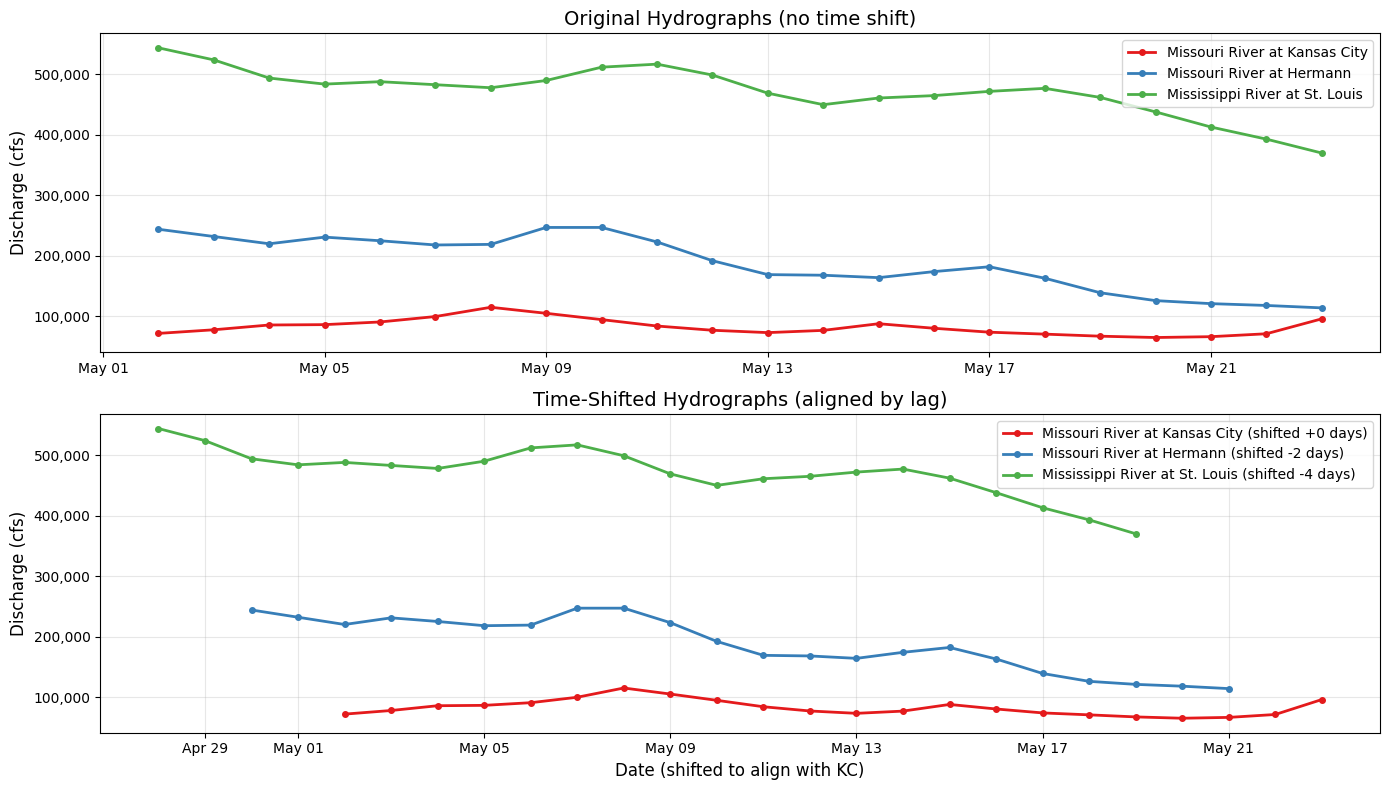


Top: Raw data showing the flood wave moving downstream
Bottom: Shifted data - peaks now align, confirming the travel time


In [37]:
# Visualize the lag-corrected hydrographs
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

# Top: Original data
for site_id, info in stations.items():
    data = station_data[site_id]
    event_data = [(d, q) for d, q in data if event_start <= d <= event_end]
    if event_data:
        dates = [d[0] for d in event_data]
        discharge = [d[1] for d in event_data]
        ax1.plot(dates, discharge, 'o-', color=info['color'], 
                linewidth=2, markersize=4, label=info['name'])

ax1.set_ylabel('Discharge (cfs)', fontsize=12)
ax1.set_title('Original Hydrographs (no time shift)', fontsize=14)
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# Bottom: Shifted to align peaks
for site_id, info in stations.items():
    data = station_data[site_id]
    
    # Apply time shift
    if site_id == '06893000':  # KC - reference
        shift = 0
    elif site_id == '06934500':  # Hermann
        shift = -lag_kc_hermann if lag_kc_hermann else 0
    else:  # St. Louis
        shift = -lag_kc_stl if lag_kc_stl else 0
    
    event_data = [(d + timedelta(days=shift), q) for d, q in data 
                  if event_start <= d <= event_end]
    if event_data:
        dates = [d[0] for d in event_data]
        discharge = [d[1] for d in event_data]
        ax2.plot(dates, discharge, 'o-', color=info['color'], 
                linewidth=2, markersize=4, label=f"{info['name']} (shifted {shift:+d} days)")

ax2.set_xlabel('Date (shifted to align with KC)', fontsize=12)
ax2.set_ylabel('Discharge (cfs)', fontsize=12)
ax2.set_title('Time-Shifted Hydrographs (aligned by lag)', fontsize=14)
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.tight_layout()
plt.show()

print("\nTop: Raw data showing the flood wave moving downstream")
print("Bottom: Shifted data - peaks now align, confirming the travel time")

## Connect to precipitation: What caused the flood?

Floods don't happen in isolation—they're caused by rainfall (or snowmelt) in the upstream watershed. Let's overlay precipitation data to see the cause-and-effect relationship.

We'll use ERA5 reanalysis precipitation data for the Missouri River basin.

In [38]:
# Define Missouri River basin (simplified polygon around KC upstream area)
# This is a rough approximation - actual basin is complex
mo_basin = ee.Geometry.Polygon([
    [-100, 42], [-94, 42], [-94, 38], [-100, 38], [-100, 42]
])

# Load ERA5 daily precipitation
era5 = ee.ImageCollection("ECMWF/ERA5_LAND/DAILY_AGGR")

# Get daily precipitation for the event period (and a week before)
precip_start = event_start - timedelta(days=7)
precip_end = event_end

print(f"Fetching precipitation data for {precip_start.strftime('%Y-%m-%d')} to {precip_end.strftime('%Y-%m-%d')}...")

daily_precip = era5.filterDate(
    precip_start.strftime('%Y-%m-%d'),
    precip_end.strftime('%Y-%m-%d')
).select('total_precipitation_sum')

# Extract basin-average precipitation for each day
def get_basin_precip(image):
    date = ee.Date(image.get('system:time_start'))
    precip_m = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=mo_basin,
        scale=10000,
        maxPixels=1e9
    ).get('total_precipitation_sum')
    # Convert m to inches
    precip_in = ee.Number(precip_m).multiply(39.37)
    return ee.Feature(None, {
        'date': date.format('YYYY-MM-dd'),
        'precip_in': precip_in
    })

precip_fc = daily_precip.map(get_basin_precip)
precip_data = precip_fc.getInfo()

# Parse results
precip_dates = []
precip_values = []
for f in precip_data['features']:
    props = f['properties']
    if props['precip_in'] is not None:
        precip_dates.append(datetime.strptime(props['date'], '%Y-%m-%d'))
        precip_values.append(props['precip_in'])

print(f"Retrieved {len(precip_dates)} days of precipitation data")

Fetching precipitation data for 2024-04-25 to 2024-05-23...
Retrieved 28 days of precipitation data


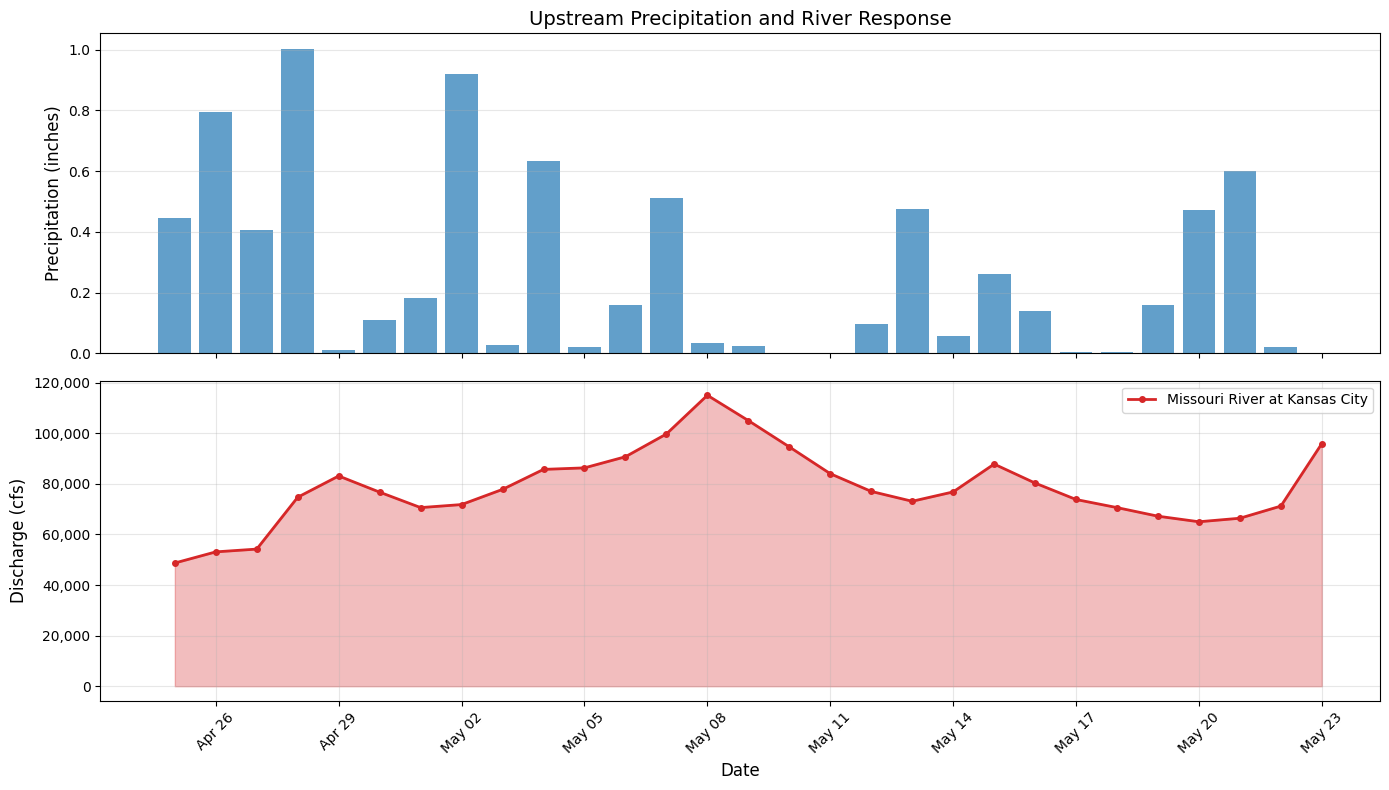


Top: Daily precipitation averaged over the upstream basin
Bottom: River discharge at Kansas City

Notice how discharge rises 1-3 days after major rainfall events.
This delay is the basin's 'response time' - how long it takes
rainfall to travel overland and through tributaries to the main river.


In [39]:
# Create combined plot: precipitation and discharge
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Top: Precipitation
ax1.bar(precip_dates, precip_values, color='#1f77b4', alpha=0.7, width=0.8)
ax1.set_ylabel('Precipitation (inches)', fontsize=12)
ax1.set_title('Upstream Precipitation and River Response', fontsize=14)
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim(bottom=0)

# Bottom: Discharge at Kansas City
kc_event = [(d, q) for d, q in station_data['06893000'] 
            if precip_start <= d <= precip_end]
if kc_event:
    dates = [d[0] for d in kc_event]
    discharge = [d[1] for d in kc_event]
    ax2.plot(dates, discharge, 'o-', color='#d62728', linewidth=2, 
             markersize=4, label='Missouri River at Kansas City')
    ax2.fill_between(dates, discharge, alpha=0.3, color='#d62728')

ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Discharge (cfs)', fontsize=12)
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# Format x-axis
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=3))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print("\nTop: Daily precipitation averaged over the upstream basin")
print("Bottom: River discharge at Kansas City")
print("\nNotice how discharge rises 1-3 days after major rainfall events.")
print("This delay is the basin's 'response time' - how long it takes")
print("rainfall to travel overland and through tributaries to the main river.")

## Key Takeaways

**What we learned:**

1. **Rivers integrate rainfall over space and time**: A storm over the basin becomes a pulse of high water that moves downstream

2. **Flood waves take time to travel**: Water doesn't teleport—it can take several days for high water in Kansas City to reach St. Louis

3. **Travel time depends on:**
   - River distance
   - Channel slope
   - Flow volume (higher flows move faster)
   - Channel geometry

4. **Forecasting applications**: Knowing travel times allows forecasters to predict when downstream cities will experience flooding

**Why this matters:**
- Emergency managers need lead time to prepare
- Dam operators coordinate releases
- Barge traffic needs to know when rivers will be too high/low
- Insurance companies assess flood risk

## Try It Yourself

Ideas to explore:

1. **Different rivers**: Try the Ohio River or the Red River of the North:
   ```python
   # Ohio River stations
   '03085000'  # Monongahela at Braddock, PA
   '03086000'  # Ohio at Sewickley, PA
   '03277200'  # Ohio at Louisville, KY
   ```

2. **Compare flood years**: Look at 2019 (major Missouri/Mississippi flooding) vs. a normal year:
   ```python
   start_date = "2019-01-01"
   end_date = "2019-12-31"
   ```

3. **Seasonal patterns**: Plot monthly average discharge to see the annual cycle. When are floods most common?

4. **Tributary contributions**: Add stations on tributaries (Kansas River, Osage River) to see how they contribute to main stem flooding

5. **Instantaneous data**: Use the USGS instantaneous values (15-minute data) for finer resolution:
   ```python
   base_url = "https://waterservices.usgs.gov/nwis/iv/"  # instead of /dv/
   ```

6. **Historic floods**: Compare the 1993 Great Flood to 2024. The 1993 flood was the most destructive in US history for the Mississippi basin.

7. **Low flows**: Look at summer drought conditions. When discharge drops, navigation becomes difficult and water quality issues emerge.

8. **Find your local stream**: USGS has gages on streams of all sizes. Find one near you at [waterdata.usgs.gov](https://waterdata.usgs.gov/nwis)